In [1]:

import h5py
import numpy as np

import numpy as np
from sklearn.model_selection import train_test_split

# To get the images and labels from file

with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
print("Done")
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
print("Done")
X_train, y_train, X_test, y_test = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]
print("Done")

# # building the input vector from the 32x32 pixels
X_train = X_train.reshape(X_train.shape[0], 256, 256, 3)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training




Done
Done
Done


In [2]:
%matplotlib notebook

In [3]:
#X_train = X_train.reshape(len(X_train), -1).astype(np.float32)
#X_test = X_test.reshape(len(X_test), -1).astype(np.float32)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

mean_image = X_train.mean(axis=0)
std_image = X_train.std(axis=0)

X_train -= mean_image
X_train /= std_image

X_test -= mean_image
X_test /= std_image


In [4]:
X_train = X_train.reshape(15962, 3, 256, 256)
X_test = X_test.reshape(1774, 3, 256, 256)

In [48]:
import mygrad as mg
import torch
from torch import tensor
import torch.nn as nn
relu = nn.functional.relu

import torch.nn.functional as F



class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(59536, 120)
        #238144 #59536 
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def accuracy(predictions, truth):
    """
    Returns the mean classification accuracy for a batch of predictions.
    
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points
    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
    """
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean((torch.argmax(prediction, dim=1) == truth).cpu().numpy())
    @property
    def parameters(self):
        return (self.conv1 + self.pool + self.conv2 + self.fc1 + self.fc2 + self.fc3)

In [6]:


train_data = torch.tensor(X_train)
test_data = torch.tensor(y_train, dtype=torch.int64)

X = torch.tensor(X_test)
Y = torch.tensor(y_test, dtype=torch.int64)




In [7]:

train_data.shape

torch.Size([15962, 3, 256, 256])

<IPython.core.display.Javascript object>


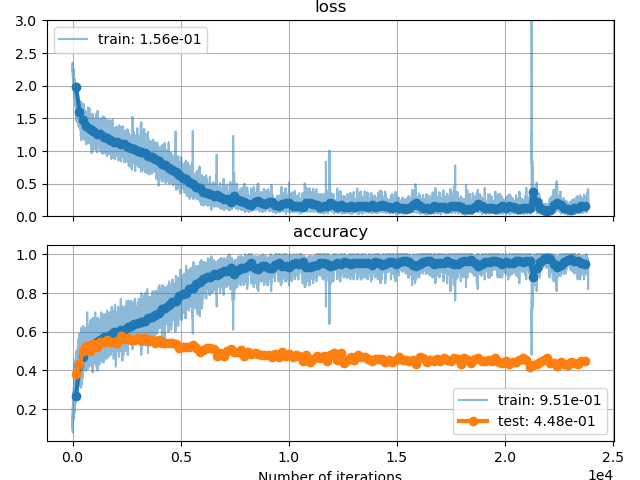

In [44]:
from noggin import create_plot
 
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

ax[0].set_ylim(0, 3)
batch_size = 100


In [133]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def save_model(model, Path):
    torch.save(model.state_dict(), Path) 
    

model = Model().to(device)
model.load_state_dict(torch.load("week4model1"))
model.eval()
optim = torch.optim.Adam(model.parameters(), weight_decay=5E-3)


Model(
  (conv1): Conv2d(3, 36, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(36, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=238144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [49]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model().to(device)
# initialize the optimizer
optim = torch.optim.Adam(model.parameters(), weight_decay=5E-3)
print(device)

cuda


In [46]:
torch.cuda.empty_cache()

In [50]:

for epoch_cnt in range(150):
    idxs = np.arange(len(X_train))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(0, len(X_train)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = train_data[batch_indices]# random batch of our training data
        torch.cuda.empty_cache()
        batch = torch.tensor(batch).to(device)
        
        prediction = model(batch)
        del batch
        torch.cuda.empty_cache()
        
        truth = test_data[batch_indices]
        truth = torch.tensor(truth).to(device)
     
        # Although its name does not indicate this, the `cross_entropy` loss
        # here also *includes a softmax* before computing the actual cross-entropy.
        loss = nn.functional.cross_entropy(prediction, truth)
        acc = accuracy(prediction, truth)
        loss.backward()
        
        del truth
        torch.cuda.empty_cache()
        
        optim.step()
        
        # Unlike in MyGrad, after you perform a gradient-based step with your optimizer, you
        # must explicitly delete/zero-out the gradients of your model's parameters
        # once you are done with them. MyGrad handles this for us, but PyTorch does not.
        optim.zero_grad()  
        
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size, plot=True)
    
    # This context manager simply signals to pytorch that we will not be 
    # computing any gradients (since we are only evaluating our model on
    # test data, not training on it). This will allow PyTorch to optimize
    # its computation
    with torch.autograd.no_grad():
        for batch_cnt in range(0, len(X_test)//batch_size):
            idxs = np.arange(len(X_test))
            batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
            batch = X[batch_indices] 
            torch.cuda.empty_cache()
            batch = torch.tensor(batch).to(device)
            prediction = model(batch)
            del batch
            torch.cuda.empty_cache()
            truth = Y[batch_indices]
            truth = torch.tensor(truth).to(device)
            acc = accuracy(prediction, truth)
            del truth
            torch.cuda.empty_cache()
            plotter.set_test_batch({ "accuracy" : acc},
                                     batch_size=batch_size)
    plotter.set_train_epoch()
    plotter.set_test_epoch()  

C:\Users\stanl\AppData\Local\Temp\ipykernel_23296\1622993902.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch).to(device)
C:\Users\stanl\AppData\Local\Temp\ipykernel_23296\1622993902.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truth = torch.tensor(truth).to(device)
C:\Users\stanl\AppData\Local\Temp\ipykernel_23296\1622993902.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch).to(device)
C:\Users\stanl\AppData\Local\Temp\ipykernel_23296\1622993902.py:53: UserWarning: To co

In [18]:
save_model(model, "week4model1")




NameError: name 'save_model' is not defined

In [19]:

import matplotlib.pyplot as plt

labels = ('disturbed', 'merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Round Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on Without Bulge', 'Edge-on with Bulge')
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
print("Done")
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
print("Done")
X_train, y_train, X_test, y_test = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]
print("Done")

# # building the input vector from the 32x32 pixels
X_train = X_train.reshape(X_train.shape[0], 256, 256, 3)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_test = X_test.reshape(1774, 3, 256, 256)





Done
Done
Done


In [21]:
import matplotlib.pyplot as plt

labels = ('disturbed', 'merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Round Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on Without Bulge', 'Edge-on with Bulge')
def plot_model_prediction(index):
    
    true_label_index = y_test[index]
    true_label = labels[true_label_index]

    with mg.no_autodiff:
        # you must pass in a shape-(1, 3072) array
        torch.cuda.empty_cache()
        
        batch = torch.tensor(X_test[index: index + 1]).to(device)
        prediction = model(batch)

        # largest score indicates the prediction
        
        predicted_label_index = np.argmax(prediction.detach().cpu().numpy(), axis=1).item()
        predicted_label = labels[predicted_label_index]

    fig, ax = plt.subplots()

    # matplotlib wants shape-(H, W, C) images, with unsigned 8bit pixel values
    X_test1 = X_test.reshape(1774, 256, 256, 3 )
    
    img = X_test1[index].astype("uint8")
    print(img.min(), img.max())

    ax.imshow(img)
    ax.set_title(f"Predicted: {predicted_label}\nTruth: {true_label}")
    return fig, ax

<IPython.core.display.Javascript object>


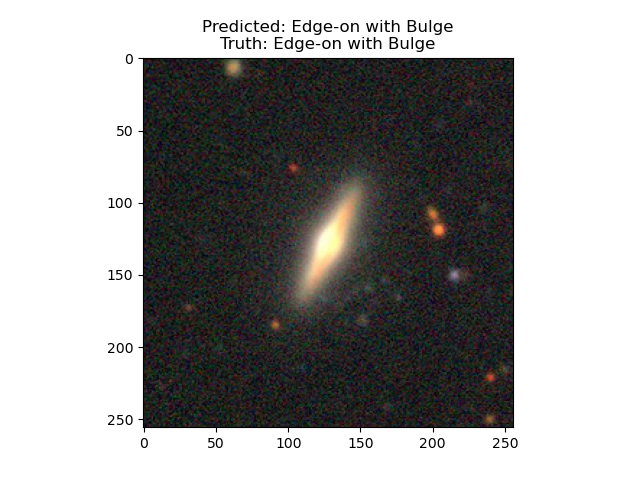

0 255


In [62]:

index = np.random.randint(0, len(X_test))  # pick a random test-image index

plot_model_prediction(index);